In [1]:
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_height, img_width = (224,224)
batch_size = 32

train_data_dir = r"dataset\output2\train"
valid_data_dir = r"dataset\output2\val"
test_data_dir  = r"dataset\output2\test"

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4)


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data


valid_generator = train_datagen.flow_from_directory(
    valid_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 203 images belonging to 4 classes.
Found 43 images belonging to 4 classes.


In [4]:
test_generator = train_datagen.flow_from_directory(
    test_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 45 images belonging to 4 classes.


In [5]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [6]:
train_generator.num_classes

4

In [7]:
base_model = ResNet50(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

model.fit(train_generator,
                         epochs = 100)

Epoch 1/100
7/7 [==============================] - 44s 5s/step - loss: 5.0160 - accuracy: 0.2764
Epoch 2/100
7/7 [==============================] - 43s 6s/step - loss: 3.7817 - accuracy: 0.4008
Epoch 3/100
7/7 [==============================] - 47s 6s/step - loss: 2.2234 - accuracy: 0.3779
Epoch 4/100
7/7 [==============================] - 48s 7s/step - loss: 1.0011 - accuracy: 0.5683
Epoch 5/100
7/7 [==============================] - 49s 7s/step - loss: 0.9982 - accuracy: 0.5795
Epoch 6/100
7/7 [==============================] - 49s 7s/step - loss: 1.1386 - accuracy: 0.5380
Epoch 7/100
7/7 [==============================] - 49s 7s/step - loss: 0.8480 - accuracy: 0.6335
Epoch 8/100
7/7 [==============================] - 50s 7s/step - loss: 0.8677 - accuracy: 0.6094
Epoch 9/100
7/7 [==============================] - 49s 7s/step - loss: 0.8157 - accuracy: 0.6663
Epoch 10/100
7/7 [==============================] - 49s 7s/step - loss: 0.8317 - accuracy: 0.6720
Epoch 11/100
7/7 [===========

7/7 [==============================] - 48s 7s/step - loss: 0.2068 - accuracy: 0.9469
Epoch 85/100
7/7 [==============================] - 48s 6s/step - loss: 0.2888 - accuracy: 0.8868
Epoch 86/100
7/7 [==============================] - 48s 7s/step - loss: 0.2921 - accuracy: 0.9088
Epoch 87/100
7/7 [==============================] - 48s 7s/step - loss: 0.3950 - accuracy: 0.8299
Epoch 88/100
7/7 [==============================] - 48s 7s/step - loss: 0.3092 - accuracy: 0.8909
Epoch 89/100
7/7 [==============================] - 48s 7s/step - loss: 0.3596 - accuracy: 0.8370
Epoch 90/100
7/7 [==============================] - 48s 7s/step - loss: 0.3874 - accuracy: 0.8433
Epoch 91/100
7/7 [==============================] - 48s 7s/step - loss: 0.2887 - accuracy: 0.8871
Epoch 92/100
7/7 [==============================] - 48s 7s/step - loss: 0.2643 - accuracy: 0.9014
Epoch 93/100
7/7 [==============================] - 48s 7s/step - loss: 0.2528 - accuracy: 0.9199
Epoch 94/100
7/7 [===============

In [8]:
model.save('dataset\Saved_Model\ResNet50_Carcass.h5')

In [9]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

45/45 - 14s - loss: 0.8696 - accuracy: 0.6889

Test accuracy: 0.6888889074325562


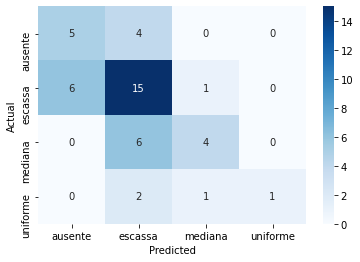

test accuracy : 55.55555555555556


In [10]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model("dataset\Saved_Model\ResNet50_Carcass.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]


out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode='categorical',
    subset='training') # set as training data

Found 203 images belonging to 4 classes.


In [12]:
test_generator = train_generator

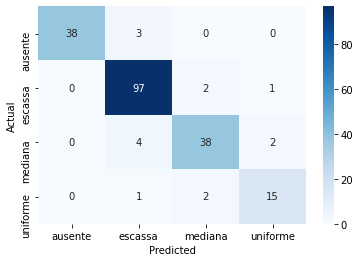

test accuracy : 92.61083743842364


In [13]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model("dataset\Saved_Model\ResNet50_Carcass.h5")
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]


out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))